In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import seaborn as sns
import cartopy.crs as ccrs
import pandas as pd
import tarfile

from matplotlib.ticker import FormatStrFormatter
from matplotlib import gridspec, colorbar, colors

C:\Users\ylinh\Anaconda3\envs\nasa\lib\site-packages\pyproj\__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [2]:
path = 'C:/Users/ylinh/OneDrive - UW/NASA Sea Ice/data/'

# CERES Data
ceres = xr.open_dataset(path+'CERES_EBAF_Ed4.1_Subset_200003-202203.nc')
ceres_synoptic = xr.open_dataset(path+'CERES_SYN1deg-Month_Terra-Aqua-MODIS_Ed4.1_Subset_200003-202203 (1).nc')
# ceres = ceres.sel(time=ceres.time.dt.month.isin(np.arange(3,11)))
ceres = ceres.sel(time=ceres.time.dt.year.isin(np.arange(2000,2018)))
# ceres_synoptic = ceres_synoptic.sel(time=ceres_synoptic.time.dt.month.isin(np.arange(3,11)))
ceres_synoptic = ceres_synoptic.sel(time=ceres_synoptic.time.dt.year.isin(np.arange(2000,2018)))

df = pd.read_pickle('weighted_deseasonalized_avg_CERES')
# df = df[(df.index.month >= 3) & (df.index.month <= 10)]
df = df[(df.index.year >= 2000) & (df.index.year <= 2017)]

# Load and shape ocn fraction data
ocn_fraction = np.loadtxt(path+'water_one_degree.dat')
ocn_fraction = np.reshape(ocn_fraction, (180, 360))
ocn_fraction = np.flip(ocn_fraction,axis=0)
ocn_fraction = ocn_fraction[-30:,:]
print(ocn_fraction.shape)

# Load sea ice extent
icearea = tarfile.open(path+'icearea.tar', mode='r')
filenames = icearea.getnames()
filenames.remove(filenames[0])
filenames.sort()

seaice_area = []
dates = pd.date_range(start='01/01/2000', end='12/15/2017', freq='MS')
for i, file in enumerate(filenames):
    seaice_area = np.append(seaice_area, np.loadtxt(path+file, usecols=1))
#     print('Reading '+str(file))
seaice_area = pd.DataFrame(seaice_area, columns=['seaice_area'], index=dates)
seaice_area = seaice_area.iloc[2:]

# Use lat/lon coords from subset CERES Arctic data
lat = np.array(ceres['lat'])
lon = np.array(ceres['lon'])
lonGrid, latGrid = np.meshgrid(lon, lat)

(30, 360)


In [3]:
ebaf_var = ['toa_sw_all_mon', 
'toa_lw_all_mon', 
'toa_net_all_mon', 
'solar_mon', 
'cldarea_total_daynight_mon', 
'cldpress_total_daynight_mon', 
'cldtau_total_day_mon', 
'cldtemp_total_daynight_mon', 
'sfc_sw_down_all_mon', 
'sfc_sw_up_all_mon', 
'sfc_lw_down_all_mon', 
'sfc_lw_up_all_mon']

ebaf_TOA = ebaf_var[0:4]
ebaf_sfc = ebaf_var[8:12]
ebaf_cloud = ebaf_var[4:8]

synoptic_var = ['toa_sw_all_mon',
'toa_lw_all_mon',
'cldarea_total_mon',
'cldtau_total_mon',
'lwp_total_mon',
'iwp_total_mon',
'cldwatrad_total_mon',
'cldicerad_total_mon',
'cldphase_total_mon',
'ini_sfc_sw_up_all_mon',
'ini_sfc_sw_down_all_mon',
'ini_albedo_mon']

synoptic_TOA = synoptic_var[0:2]
synoptic_sfc = synoptic_var[9:12]
synoptic_cloud = synoptic_var[2:9]

weight = np.cos(np.deg2rad(latGrid))*ocn_fraction
var_mean = np.zeros((12, len(ceres['time'])))

for i, var in enumerate(ebaf_var):
    var_mean[i] = np.array([np.average(ceres[var][j], weights=weight) for j in range(len(ceres[var]))])
ceres_df = pd.DataFrame(var_mean.transpose(), columns=ebaf_var, index=ceres['time'].to_numpy())

var_mean = np.zeros((12, len(ceres_synoptic['time'])))
for i, var in enumerate(synoptic_var):
    var_mean[i] = np.array([np.average(ceres_synoptic[var][j], weights=weight) for j in range(len(ceres_synoptic[var]))])
    
synoptic_df = pd.DataFrame(var_mean.transpose(), columns=synoptic_var, index=ceres_synoptic['time'].to_numpy())

# Merge sea ice extent data
# synoptic_df = synoptic_df.merge(seaice_area,left_index=True,right_index=True)
# ceres_df = ceres_df.merge(seaice_area,left_index=True,right_index=True)
# df = df.merge(seaice_area,left_index=True,right_index=True)

In [4]:
# Calculate net SW/LW
df['sfc_sw_net'] = df['sfc_sw_down_all_mon'] - df['sfc_sw_up_all_mon']
ceres_df['sfc_sw_net'] = ceres_df['sfc_sw_down_all_mon'] - ceres_df['sfc_sw_up_all_mon']

df['sfc_lw_net'] = df['sfc_lw_down_all_mon'] - df['sfc_lw_up_all_mon']
ceres_df['sfc_lw_net'] = ceres_df['sfc_lw_down_all_mon'] - ceres_df['sfc_lw_up_all_mon']

synoptic_df['ini_sfc_sw_net'] = synoptic_df['ini_sfc_sw_down_all_mon'] - synoptic_df['ini_sfc_sw_up_all_mon']

In [5]:
df

,toa_sw_all_mon,toa_lw_all_mon,toa_net_all_mon,solar_mon,cldarea_total_daynight_mon,cldpress_total_daynight_mon,cldtau_total_day_mon,cldtemp_total_daynight_mon,sfc_sw_down_all_mon,sfc_sw_up_all_mon,sfc_lw_down_all_mon,sfc_lw_up_all_mon,sfc_sw_net,sfc_lw_net
2000-03-15,0.128033,-3.313942,3.278047,0.092523,5.927741,43.875218,NaN,2.195308,-0.035321,0.013297,1.974970,-5.966164,-0.048618,7.941134
2000-04-15,0.053530,3.903000,-3.725353,0.230829,1.869407,35.809090,NaN,1.986593,0.478858,0.395311,0.148424,-0.077547,0.083547,0.225971
2000-05-15,2.864582,-0.096217,-1.649201,1.119468,2.262250,33.398660,1.045275,1.585863,-0.334115,1.467258,4.016563,-0.629854,-1.801373,4.646417
2000-06-15,2.773715,-1.380170,0.179844,1.571762,-2.433165,-3.170151,-0.199801,-0.482298,2.576409,3.238378,-2.648275,-4.992049,-0.661969,2.343774
2000-07-15,6.691179,-2.072646,-3.458562,1.161852,-2.471276,-12.576936,0.365407,-0.648878,2.748192,8.078965,-4.414184,-5.058241,-5.330772,0.644057
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-15,2.157062,-1.184987,-0.932157,0.038887,1.191594,-7.481729,0.247199,-0.310844,1.757879,-0.009394,0.208788,0.755409,1.767273,-0.546620
2017-09-15,-0.637427,-1.510258,1.574384,-0.571284,1.264937,-17.569863,0.093801,-0.948823,0.000904,-2.598893,0.672995,1.141742,2.599797,-0.468747
2017-10-15,0.634833,-1.362972,-0.163974,-0.893239,2.155051,-12.414824,0.213281,-0.451065,-3.590260,-2.304431,2.496086,1.920706,-1.285829,0.575380
2017-11-15,-0.961913,1.243091,-1.067421,-0.786474,-0.630313,2.174609,0.020641,0.535256,-0.803473,-0.796675,2.068313,1.278596,-0.006797,0.789716


In [6]:
# df_corr = df.corr()
# df_corr = round(df_corr,2)

# ceres_df_corr = ceres_df.corr()
# ceres_df_corr = round(ceres_df_corr,2)

# synoptic_df_corr = synoptic_df.corr()
# synoptic_df_corr = round(synoptic_df_corr,2)

def corrWith(df, seaice_area):
    seaice_area = seaice_area.reset_index().drop(columns=['index'])
    
    df = df.reset_index().drop(columns=['index'])
    df = df.merge(seaice_area, left_index=True, right_index=True, suffixes=(None,None))
    
    df_corr = df.corr()
    df_corr = round(df_corr,2)
    return df_corr

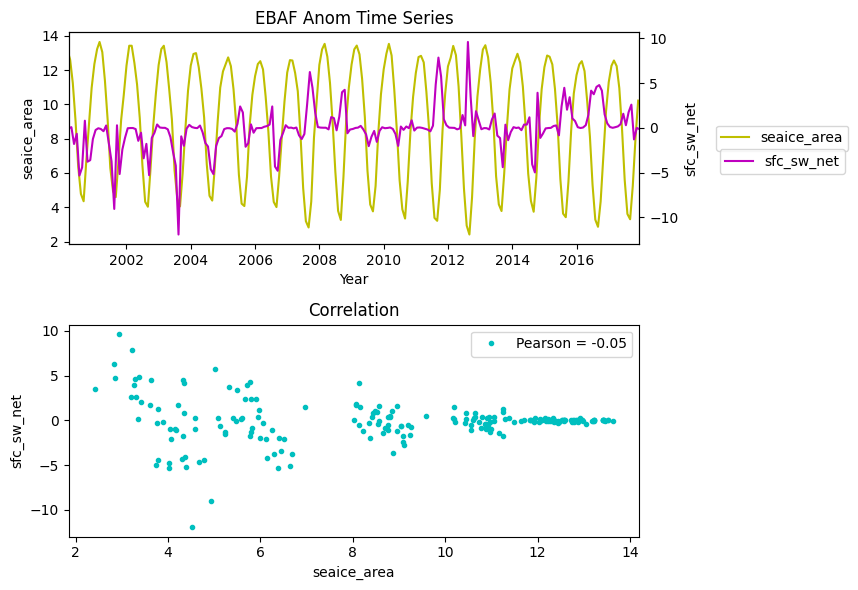

In [7]:
xvar = seaice_area['seaice_area']
yvar = 'sfc_sw_net'

fig, ax = plt.subplots(2,1, figsize=(9,6))
ax.flatten()

ax2 = ax[0].twinx()
ax[0].plot(seaice_area['seaice_area'], 'y', label='seaice_area')
ax[0].set_ylabel('seaice_area')
ax2.plot(df[yvar], 'm', label=yvar)
ax2.set_ylabel(yvar)
ax[0].set_xlim(df.index.date[0],df.index.date[-1])
ax[0].set_xlabel('Year')
ax2.legend(bbox_to_anchor=(1.25, .39), loc='center')
ax[0].legend(bbox_to_anchor=(1.25, .5), loc='center')
ax[0].set_title('EBAF Anom Time Series')

df_corr = corrWith(df, seaice_area)
ax[1].plot(seaice_area['seaice_area'], df[yvar], 'c.', label='Pearson = '+str(df_corr[xvar.name][yvar]))
ax[1].set_xlabel('seaice_area')
ax[1].set_ylabel(yvar)
ax[1].set_title('Correlation')
ax[1].legend()

plt.tight_layout()

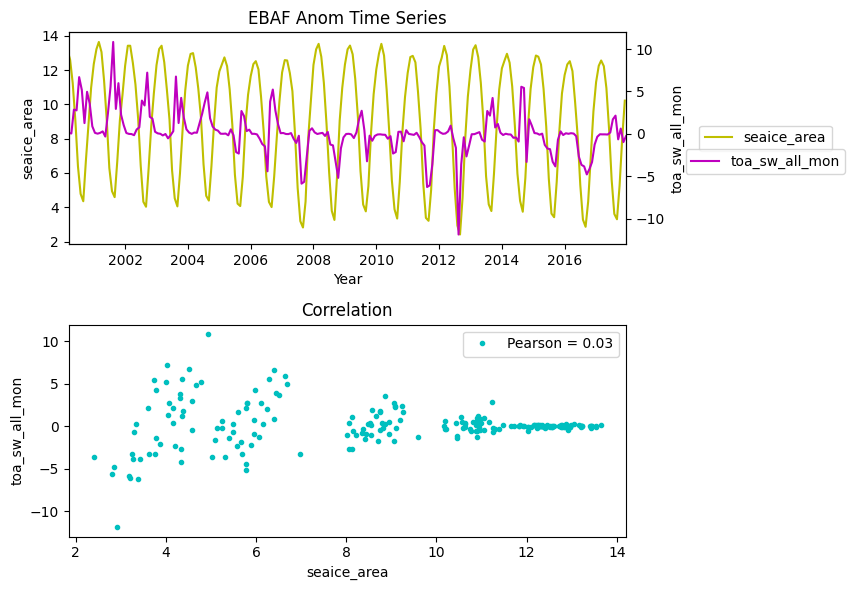

In [8]:
xvar = seaice_area['seaice_area']
yvar = 'toa_sw_all_mon'

fig, ax = plt.subplots(2,1, figsize=(9,6))
ax.flatten()

ax2 = ax[0].twinx()
ax[0].plot(xvar, 'y', label=xvar.name)
ax[0].set_ylabel(xvar.name)
ax2.plot(df[yvar], 'm', label=yvar)
ax2.set_ylabel(yvar)
ax[0].set_xlim(df.index.date[0],df.index.date[-1])
ax[0].set_xlabel('Year')
ax2.legend(bbox_to_anchor=(1.25, .39), loc='center')
ax[0].legend(bbox_to_anchor=(1.25, .5), loc='center')
ax[0].set_title('EBAF Anom Time Series')

df_corr = corrWith(df, seaice_area)
ax[1].plot(xvar, df[yvar], 'c.', label='Pearson = '+str(df_corr[xvar.name][yvar]))
ax[1].set_xlabel(xvar.name)
ax[1].set_ylabel(yvar)
ax[1].set_title('Correlation')
ax[1].legend()

plt.tight_layout()

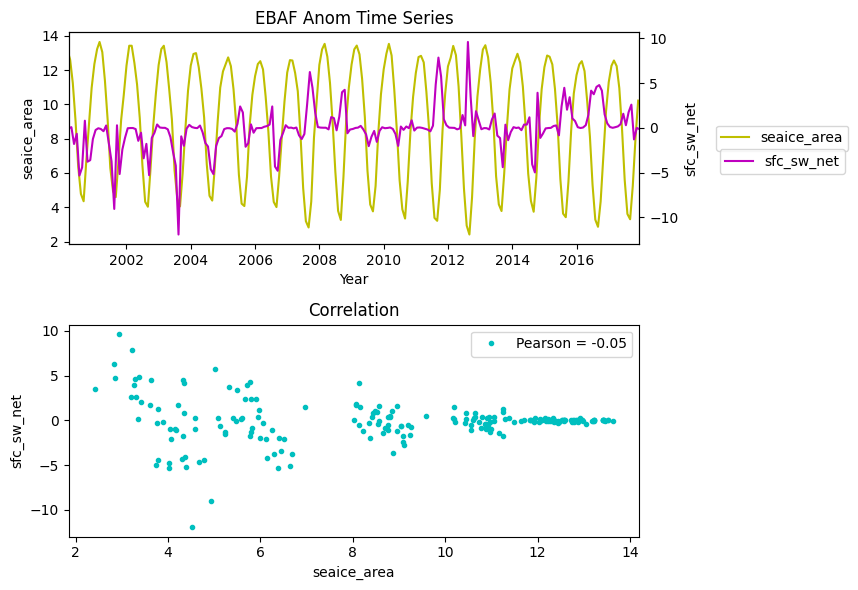

In [9]:
xvar = seaice_area['seaice_area']
yvar = 'sfc_sw_net'

fig, ax = plt.subplots(2,1, figsize=(9,6))
ax.flatten()

ax2 = ax[0].twinx()
ax[0].plot(xvar, 'y', label=xvar.name)
ax[0].set_ylabel(xvar.name)
ax2.plot(df[yvar], 'm', label=yvar)
ax2.set_ylabel(yvar)
ax[0].set_xlim(df.index.date[0],df.index.date[-1])
ax[0].set_xlabel('Year')
ax2.legend(bbox_to_anchor=(1.25, .39), loc='center')
ax[0].legend(bbox_to_anchor=(1.25, .5), loc='center')
ax[0].set_title('EBAF Anom Time Series')

df_corr = corrWith(df, seaice_area)
ax[1].plot(xvar, df[yvar], 'c.', label='Pearson = '+str(df_corr[xvar.name][yvar]))
ax[1].set_xlabel(xvar.name)
ax[1].set_ylabel(yvar)
ax[1].set_title('Correlation')
ax[1].legend()

plt.tight_layout()

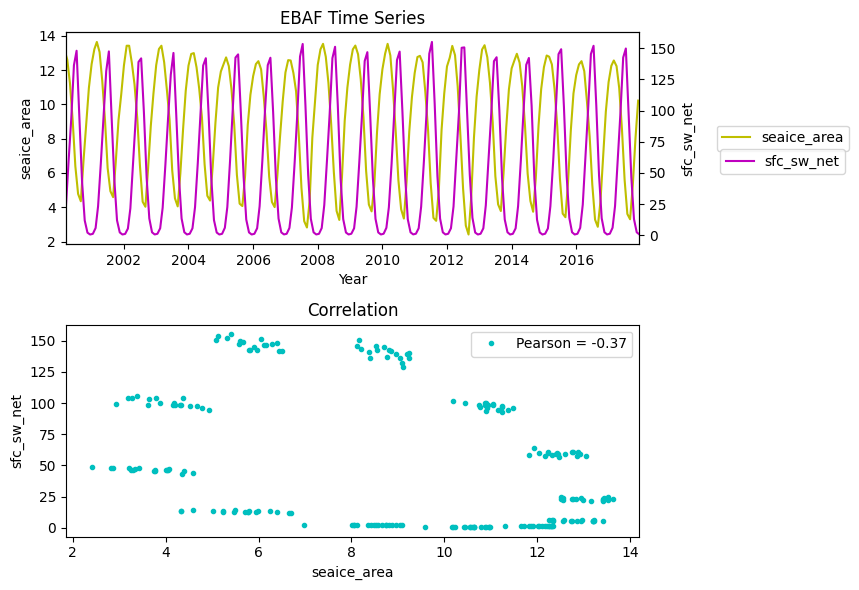

In [10]:
xvar = seaice_area['seaice_area']
yvar = 'sfc_sw_net'

fig, ax = plt.subplots(2,1, figsize=(9,6))
ax.flatten()

ax2 = ax[0].twinx()
ax[0].plot(xvar, 'y', label=xvar.name)
ax[0].set_ylabel(xvar.name)
ax2.plot(ceres_df[yvar], 'm', label=yvar)
ax2.set_ylabel(yvar)
ax[0].set_xlim(ceres_df.index.date[0],ceres_df.index.date[-1])
ax[0].set_xlabel('Year')
ax2.legend(bbox_to_anchor=(1.25, .39), loc='center')
ax[0].legend(bbox_to_anchor=(1.25, .5), loc='center')
ax[0].set_title('EBAF Time Series')

ceres_df_corr = corrWith(ceres_df, seaice_area)
ax[1].plot(xvar, ceres_df[yvar], 'c.', label='Pearson = '+str(ceres_df_corr[xvar.name][yvar]))
ax[1].set_xlabel(xvar.name)
ax[1].set_ylabel(yvar)
ax[1].set_title('Correlation')
ax[1].legend()

plt.tight_layout()

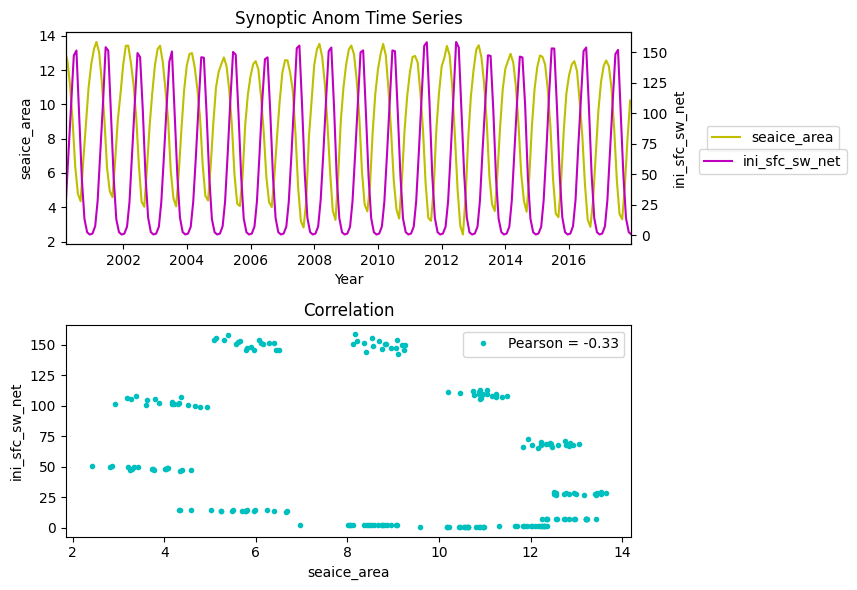

In [11]:
xvar = seaice_area['seaice_area']
yvar = 'ini_sfc_sw_net'

fig, ax = plt.subplots(2,1, figsize=(9,6))
ax.flatten()

ax2 = ax[0].twinx()
ax[0].plot(xvar, 'y', label=xvar.name)
ax[0].set_ylabel(xvar.name)
ax2.plot(synoptic_df[yvar], 'm', label=yvar)
ax2.set_ylabel(yvar)
ax[0].set_xlim(synoptic_df.index.date[0],synoptic_df.index.date[-1])
ax[0].set_xlabel('Year')
ax2.legend(bbox_to_anchor=(1.25, .39), loc='center')
ax[0].legend(bbox_to_anchor=(1.25, .5), loc='center')
ax[0].set_title('Synoptic Anom Time Series')

synoptic_df_corr = corrWith(synoptic_df, seaice_area)
ax[1].plot(xvar, synoptic_df[yvar], 'c.', label='Pearson = '+str(synoptic_df_corr[xvar.name][yvar]))
ax[1].set_xlabel(xvar.name)
ax[1].set_ylabel(yvar)
ax[1].set_title('Correlation')
ax[1].legend()

plt.tight_layout()

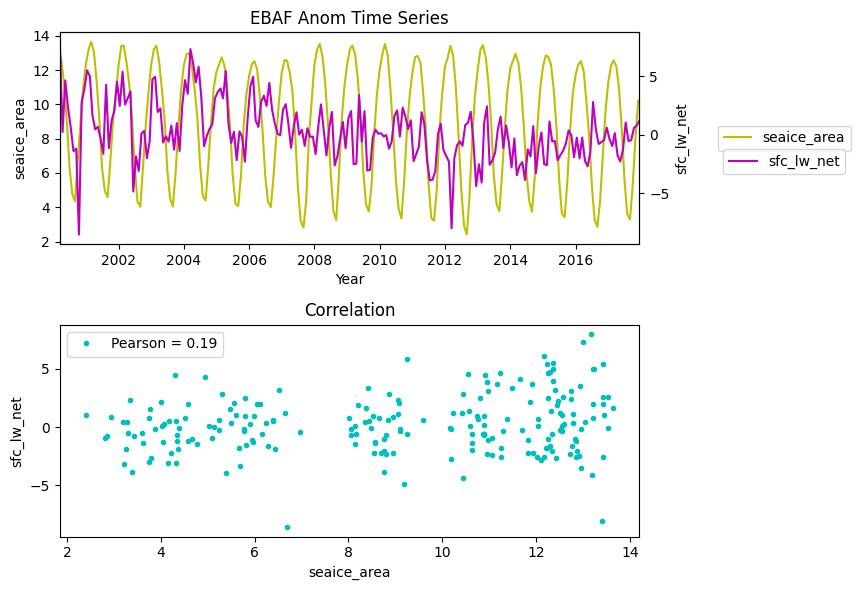

In [12]:
xvar = seaice_area['seaice_area']
yvar = 'sfc_lw_net'

fig, ax = plt.subplots(2,1, figsize=(9,6))
ax.flatten()

ax2 = ax[0].twinx()
ax[0].plot(xvar, 'y', label=xvar.name)
ax[0].set_ylabel(xvar.name)
ax2.plot(df[yvar], 'm', label=yvar)
ax2.set_ylabel(yvar)
ax[0].set_xlim(df.index.date[0],df.index.date[-1])
ax[0].set_xlabel('Year')
ax2.legend(bbox_to_anchor=(1.25, .39), loc='center')
ax[0].legend(bbox_to_anchor=(1.25, .5), loc='center')
ax[0].set_title('EBAF Anom Time Series')

df_corr = corrWith(df, seaice_area)
ax[1].plot(xvar, df[yvar], 'c.', label='Pearson = '+str(df_corr[xvar.name][yvar]))
ax[1].set_xlabel(xvar.name)
ax[1].set_ylabel(yvar)
ax[1].set_title('Correlation')
ax[1].legend()

plt.tight_layout()

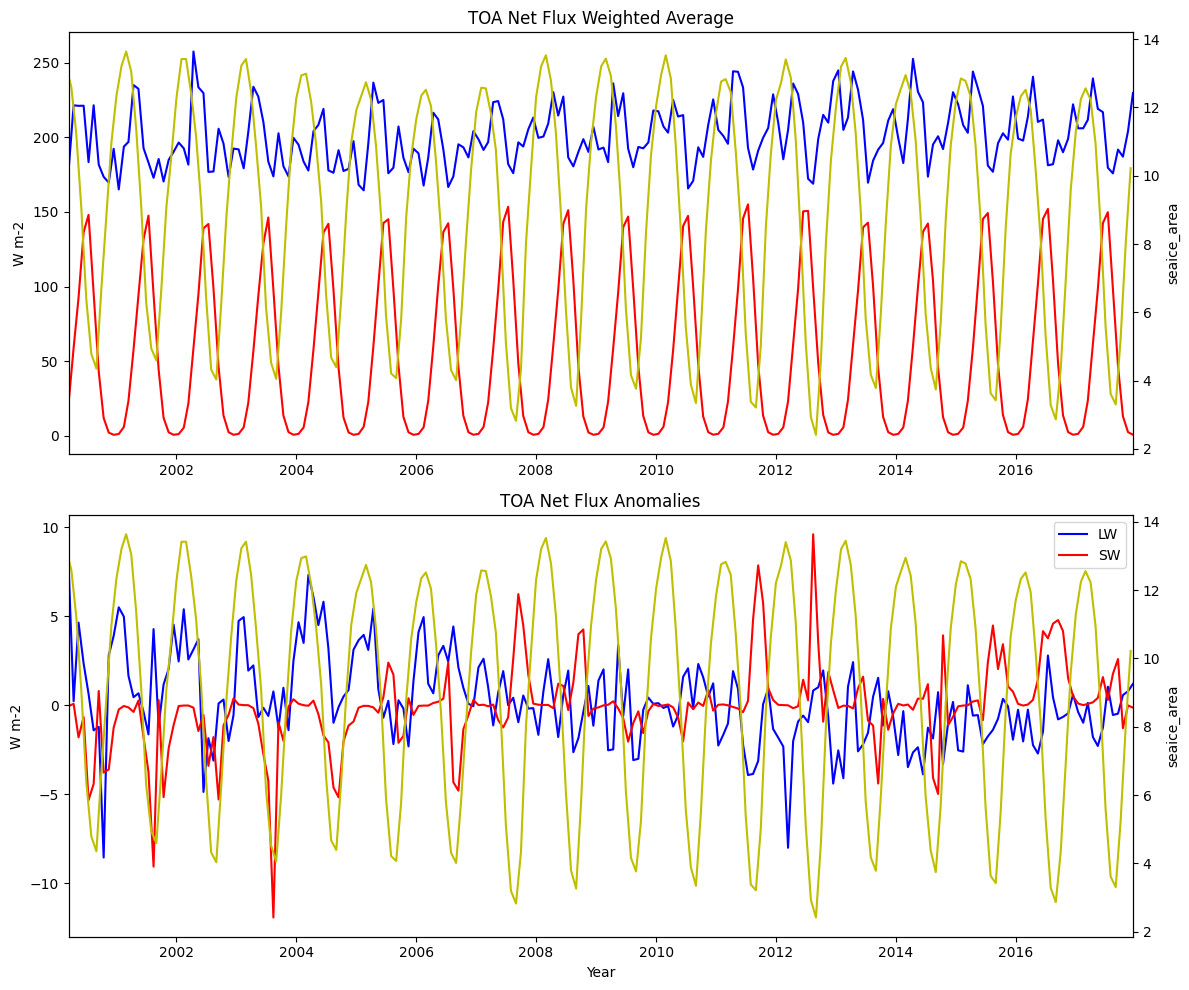

In [17]:
fig, ax = plt.subplots(2,1, figsize=(12,10))
ax.flatten()

ax2 = ax[0].twinx()
ax2.plot(seaice_area['seaice_area'], 'y', label='seaice_area')
ax2.set_ylabel('seaice_area')

ax3 = ax[1].twinx()
ax3.plot(seaice_area['seaice_area'], 'y', label='seaice_area')
ax3.set_ylabel('seaice_area')
ax[0].plot(ceres_df['sfc_lw_net']*-5, 'b', label='LW')
ax[1].plot(df['sfc_lw_net'],'b', label='LW')
ax[0].plot(ceres_df['sfc_sw_net'], 'r', label='SW')
ax[1].plot(df['sfc_sw_net'], 'r', label='SW')
           
# ax[0].legend()
ax[1].legend()

ax[0].set_xlim(ceres_df.index.date[0],ceres_df.index.date[-1])
ax[1].set_xlim(df.index.date[0],df.index.date[-1])

ax[0].set_ylabel('W m-2')
ax[1].set_ylabel('W m-2')

ax[1].set_xlabel('Year')

ax[0].set_title('TOA Net Flux Weighted Average')
ax[1].set_title('TOA Net Flux Anomalies')

fig.tight_layout()